In [155]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('Houses.csv', encoding='latin-1')

In [156]:
data.head()

,Unnamed: 0,address,city,floor,id,latitude,longitude,price,rooms,sq,year
0,0,Podgórze Zab³ocie Stanis³awa Klimeckiego,Kraków,2.0,23918.0,50.049224,19.970379,749000.0,3.0,74.05,2021.0
1,1,Praga-Po³udnie Grochowska,Warszawa,3.0,17828.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0
2,2,Krowodrza Czarnowiejska,Kraków,2.0,22784.0,50.066964,19.920025,427000.0,2.0,37.00,1970.0
3,3,Grunwald,Poznañ,2.0,4315.0,52.404212,16.882542,1290000.0,5.0,166.00,1935.0
4,4,Ochota Gotowy budynek. Stan deweloperski. Osta...,Warszawa,1.0,11770.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0


In [158]:
data.dtypes

Unnamed: 0      int64
address        object
city           object
floor         float64
id            float64
latitude      float64
longitude     float64
price         float64
rooms         float64
sq            float64
year          float64
dtype: object

In [159]:
data.duplicated().sum()


0

In [160]:
data.isna().sum()

Unnamed: 0    0
address       0
city          0
floor         0
id            0
latitude      0
longitude     0
price         0
rooms         0
sq            0
year          0
dtype: int64


#### Cleaning the data

In [164]:
data_copy = data.copy(deep=True)
data_copy.head()

,Unnamed: 0,address,city,floor,id,latitude,longitude,price,rooms,sq,year
0,0,Podgórze Zab³ocie Stanis³awa Klimeckiego,Krakow,2.0,23918.0,50.049224,19.970379,749000.0,3.0,74.05,2021.0
1,1,Praga-Po³udnie Grochowska,Warszawa,3.0,17828.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0
2,2,Krowodrza Czarnowiejska,Krakow,2.0,22784.0,50.066964,19.920025,427000.0,2.0,37.00,1970.0
3,3,Grunwald,Poznan,2.0,4315.0,52.404212,16.882542,1290000.0,5.0,166.00,1935.0
4,4,Ochota Gotowy budynek. Stan deweloperski. Osta...,Warszawa,1.0,11770.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0


In [166]:
ndc1 = data_copy.drop(columns=['Unnamed: 0','address','id'])
#Now, let's remove rows where year is less than 1800 and greater than 2022 to remove the incorrectly given data.
ndc = ndc[(ndc.year >= 1800) & (ndc.year <= 2022)]
#ndc2 = ndc1.drop(ndc1[ndc1.year <1800].index)
#ndc3 = ndc2.drop(ndc2[ndc2.year >2022].index)

ndc

,city,floor,latitude,longitude,price,rooms,sq,year,price_per_sq,sq_per_room
0,Kraków,2.0,50.049224,19.970379,749000.0,3.0,74.05,2021.0,10114.787306,24.683333
1,Warszawa,3.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0,9866.611977,24.380000
2,Kraków,2.0,50.066964,19.920025,427000.0,2.0,37.00,1970.0,11540.540541,18.500000
3,Poznañ,2.0,52.404212,16.882542,1290000.0,5.0,166.00,1935.0,7771.084337,33.200000
4,Warszawa,1.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0,9485.714286,21.000000
...,...,...,...,...,...,...,...,...,...,...
23759,Poznañ,0.0,52.449649,16.949408,543000.0,4.0,77.00,2020.0,7051.948052,19.250000
23760,Warszawa,4.0,52.186109,20.948438,910000.0,3.0,71.00,2017.0,12816.901408,23.666667
23761,Poznañ,0.0,52.397345,16.961939,430695.0,3.0,50.67,2022.0,8500.000000,16.890000
23762,Kraków,6.0,50.024231,19.959569,359000.0,2.0,38.86,2021.0,9238.291302,19.430000


In [86]:
#We also want to add column with  price per square meter and square meters per room.
price_per_sq = ndc['price'] / ndc['sq']
ndc['price_per_sq'] = price_per_sq

sq_per_room = ndc['sq'] / ndc['rooms']
ndc['sq_per_room'] = sq_per_room

In [167]:
def city_name(row):
    if row == 'Poznañ':
        return 'Poznan'
    elif row == 'Kraków':
        return 'Krakow'
    else:
        return 'Warszawa'

ndc['city'] = ndc['city'].apply(lambda x: city_name(x))
ndc.head()

,city,floor,latitude,longitude,price,rooms,sq,year,price_per_sq,sq_per_room
0,Krakow,2.0,50.049224,19.970379,749000.0,3.0,74.05,2021.0,10114.787306,24.683333
1,Warszawa,3.0,52.249775,21.106886,240548.0,1.0,24.38,2021.0,9866.611977,24.380000
2,Krakow,2.0,50.066964,19.920025,427000.0,2.0,37.00,1970.0,11540.540541,18.500000
3,Poznan,2.0,52.404212,16.882542,1290000.0,5.0,166.00,1935.0,7771.084337,33.200000
4,Warszawa,1.0,52.212225,20.972630,996000.0,5.0,105.00,2020.0,9485.714286,21.000000


In [172]:
#we divide the data into 3 cities
ndc_waw = ndc[ndc["city"].isin(['Warszawa'])]
ndc_kra = ndc[ndc["city"].isin(['Krakow'])]
ndc_poz = ndc[ndc["city"].isin(['Poznan'])]

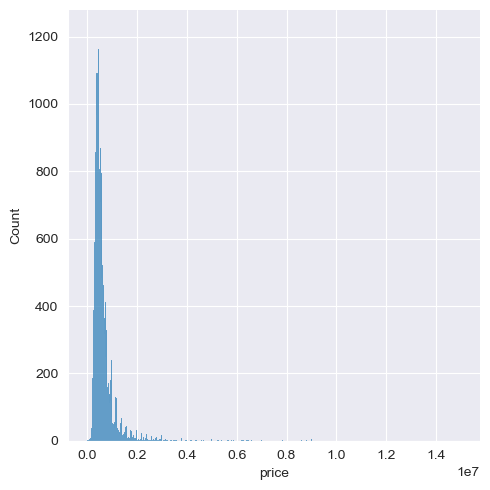

In [173]:
sns.displot(data=ndc['price'])

### Krakow

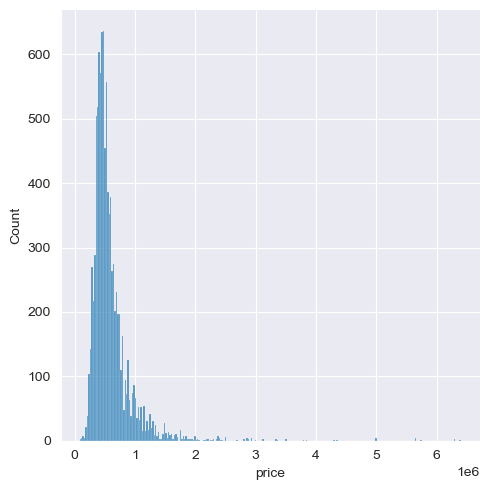

In [174]:
sns.displot(data=ndc_kra['price'])

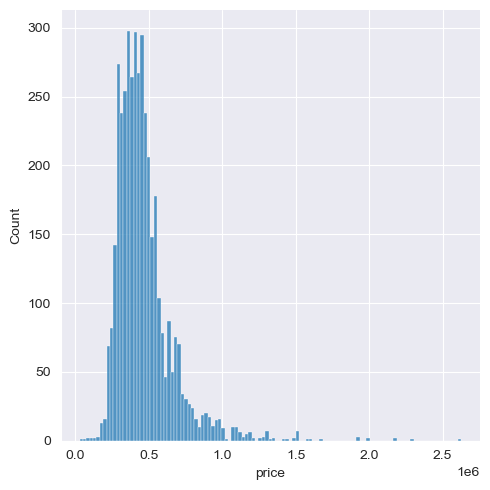

In [175]:
sns.displot(data=ndc_poz['price'])

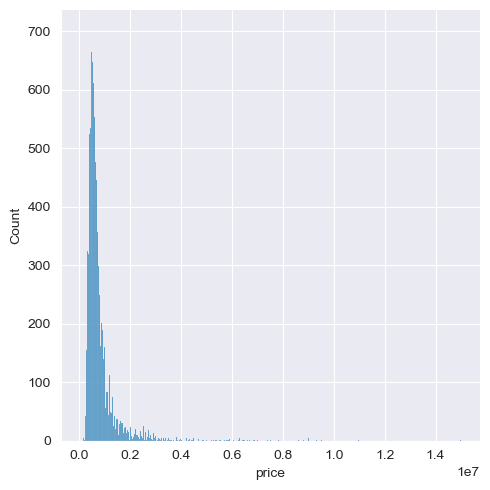

In [176]:
sns.displot(data=ndc_waw['price'])

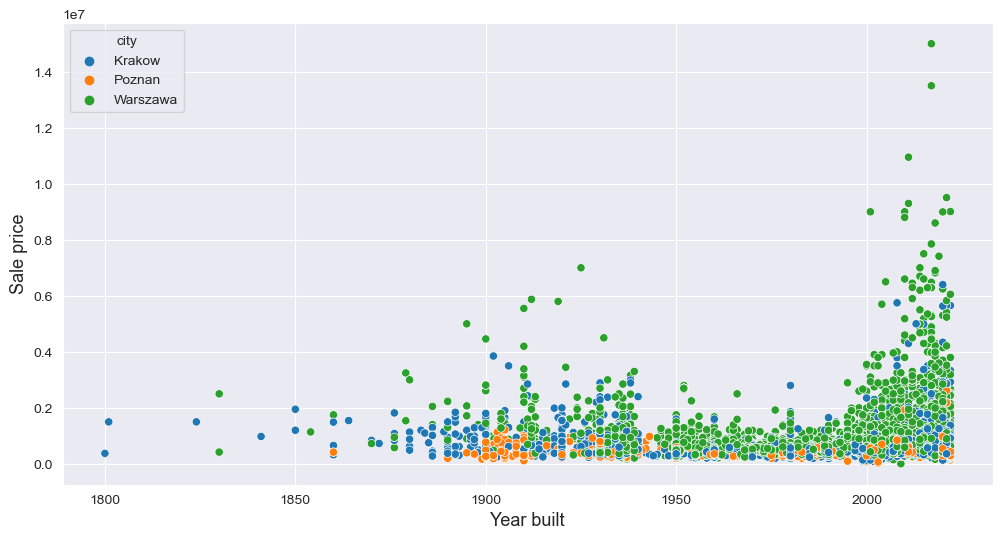

In [182]:
#fig, ax = plt.subplots()
#ax.scatter(x = ndc['year'], y = ndc['price'])
plt.figure(figsize=(12,6))
sns.scatterplot(x='year', y='price', data=ndc, hue='city', hue_order = ['Krakow', 'Poznan', 'Warszawa'])
plt.xlabel('Year built', fontsize = 13)
plt.ylabel('Sale price', fontsize = 13)
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.title("House area in square meters vs price")
sns.scatterplot(x='sq', y='price', data=df, hue='city', hue_order = ['Warszawa', 'Krakow', 'Poznan'])
plt.show()